Epoch [10/70] | Train Loss: 0.6154 | Val Loss: 0.6534
Epoch [20/70] | Train Loss: 0.5560 | Val Loss: 0.5721
Epoch [30/70] | Train Loss: 0.5028 | Val Loss: 0.4997
Epoch [40/70] | Train Loss: 0.4608 | Val Loss: 0.4513
Epoch [50/70] | Train Loss: 0.4274 | Val Loss: 0.4182
Epoch [60/70] | Train Loss: 0.4062 | Val Loss: 0.3919
Epoch [70/70] | Train Loss: 0.3765 | Val Loss: 0.3777

Average Heart Attack Risk in Test Set: 69.23%
Percentage of people predicted high risk: 61.54%

Improved Deep NN Performance:
Accuracy:  0.7692
Precision: 0.8750
Recall:    0.7778
F1 Score:  0.8235
ROC AUC:   0.8368


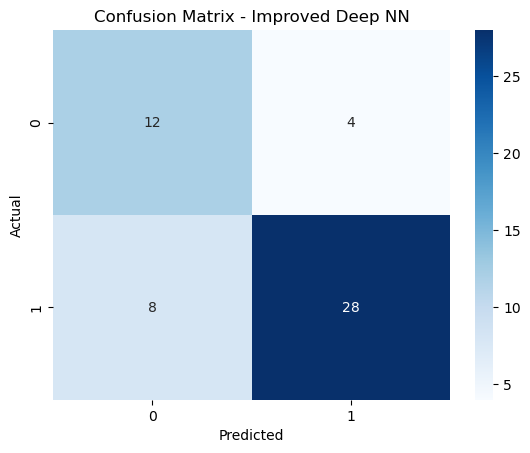

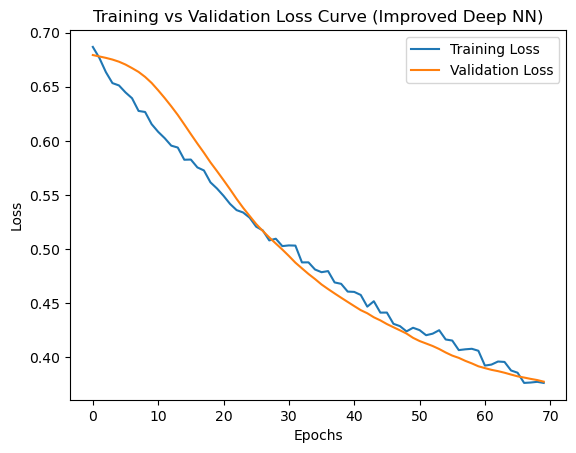

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("WesternFoodDataset_Relabeled.csv") 
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, stratify=y_train, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val   = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

class ImprovedDeepNN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedDeepNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

model = ImprovedDeepNN(X_train.shape[1])

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.8)

epochs = 70
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test)
    y_pred_probs = torch.sigmoid(y_pred_logits).numpy().flatten()
    y_test_np = y_test.numpy().flatten()

y_pred_class = (y_pred_probs >= 0.5).astype(int)
y_test_np = y_test.numpy().flatten()

avg_risk = y_test_np.mean() * 100
print(f"\nAverage Heart Attack Risk in Test Set: {avg_risk:.2f}%")

percent_high_risk = (y_pred_class.sum() / len(y_pred_class)) * 100
print(f"Percentage of people predicted high risk: {percent_high_risk:.2f}%")
acc = accuracy_score(y_test_np, y_pred_class)
prec = precision_score(y_test_np, y_pred_class)
rec = recall_score(y_test_np, y_pred_class)
f1 = f1_score(y_test_np, y_pred_class)
roc_auc = roc_auc_score(y_test_np, y_pred_probs)

print("\nImproved Deep NN Performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

cm = confusion_matrix(y_test_np, y_pred_class)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Improved Deep NN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve (Improved Deep NN)")
plt.legend()
plt.show()